# Imports

In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd 

import tensorflow
import keras

from keras.layers import *
from keras.models import *
import keras.backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import  train_test_split

import time #helper libraries
from numpy import newaxis


import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [103]:
# Try for each water point
df = pd.read_csv('https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/data/volume/21082780.csv?token=AAFQJx-5iiw8_ssxgCoKbnqcR4yiVPtjks5dNxv1wA%3D%3D')
#df = pd.read_csv('https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/data/volume/5691681.csv?token=AAFQJ9mPet46oRX2iX8tpSdqn1Lr7VwPks5dNxwSwA%3D%3D')
#df = pd.read_csv('https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/data/volume/5691708.csv?token=AAFQJ9BduPqTsjVUxgWXmf4ZT1JIIFMNks5dNxwswA%3D%3D')
#df = pd.read_csv('https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/data/volume/5691715.csv?token=AAFQJycKW7eb1d567-oDqiKVREfpvCXiks5dNxxDwA%3D%3D')
#df = pd.read_csv('https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/data/volume/8037020.csv?token=AAFQJ1VzwooGHh191Vd2r669nFb_dsekks5dNxxVwA%3D%3D')

In [104]:
#Check the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
date      466 non-null object
volume    466 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.4+ KB


In [105]:
#Name columns 
df.columns = ['date','volume']
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 2 columns):
date      466 non-null object
volume    466 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.4+ KB


In [106]:
df.date = pd.to_datetime(df['date'].astype(str), format='%d/%m/%Y')
df.set_index('date', inplace=True)

In [107]:
len(df)

466

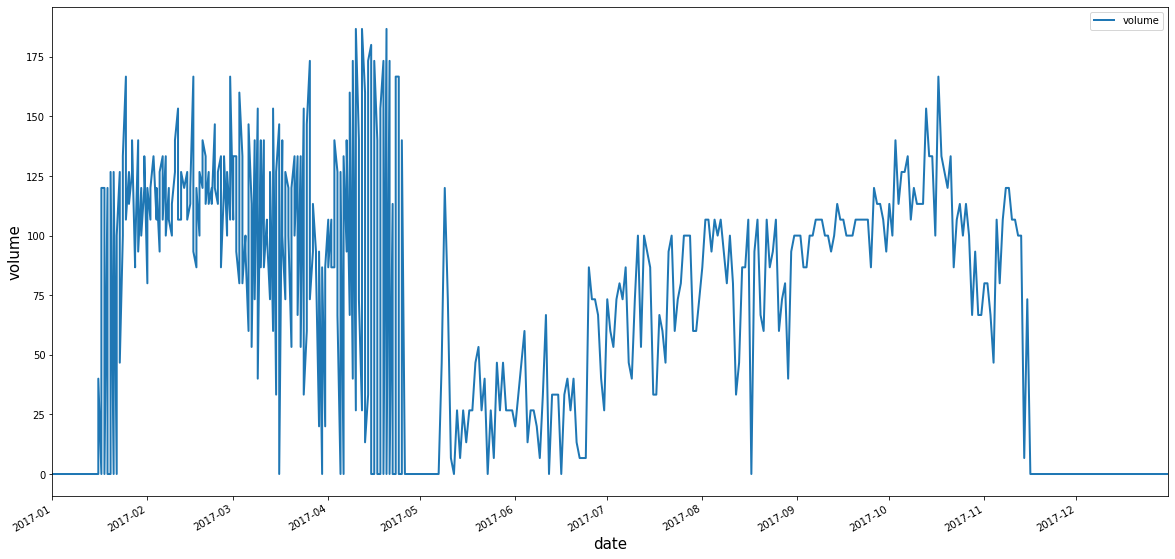

In [108]:
df.plot(figsize=(20,10), linewidth=2, fontsize=10)
plt.xlabel('date', fontsize=15);
plt.ylabel('volume', fontsize=15);


Implement an LSTM with the following architecture
<img src="https://raw.github.ibm.com/mwa-kenya/groundwater-advisor/master/flowtimeSeriesAnalysis/img/lstm.PNG?token=AAFQJ6cnHkfPyFweGqPqmpB3a4n-LuU1ks5dN_lwwA%3D%3D" width="600" />

# Feature scaling 
LSTMs are sensitive to the scale of the input data due to the activation functions (sigmoid or tanh). Need to normalize the data. We use the MinMaxScaler class from scikit-learn. 

In [118]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)

# Split to train and test sets
67% of the data is taken as a trainset, 33% is testdata

In [119]:

train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test =df[0:train_size,:], df[train_size:len(df),:]
print(len(train), len(test))

372 94


Create a function that takes the dataset X is the volume at a given time (t) and Y is the volume at the next time (t + 1). 

In [120]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [121]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [122]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [123]:

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 2s - loss: 0.0868
Epoch 2/10
 - 1s - loss: 0.0395
Epoch 3/10
 - 1s - loss: 0.0274
Epoch 4/10
 - 1s - loss: 0.0203
Epoch 5/10
 - 1s - loss: 0.0176
Epoch 6/10
 - 1s - loss: 0.0171
Epoch 7/10
 - 1s - loss: 0.0169
Epoch 8/10
 - 1s - loss: 0.0169
Epoch 9/10
 - 1s - loss: 0.0169
Epoch 10/10
 - 1s - loss: 0.0170


Use the model to make predictions on the train and test data then invert the predictions from the transformation. 
RMSE values are calculated to gauge model performance. 

In [124]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.13 RMSE
Test Score: 0.15 RMSE


Plotting... shifting trick adopted from Machine Learning Mastery. Plots results from train and test data. 

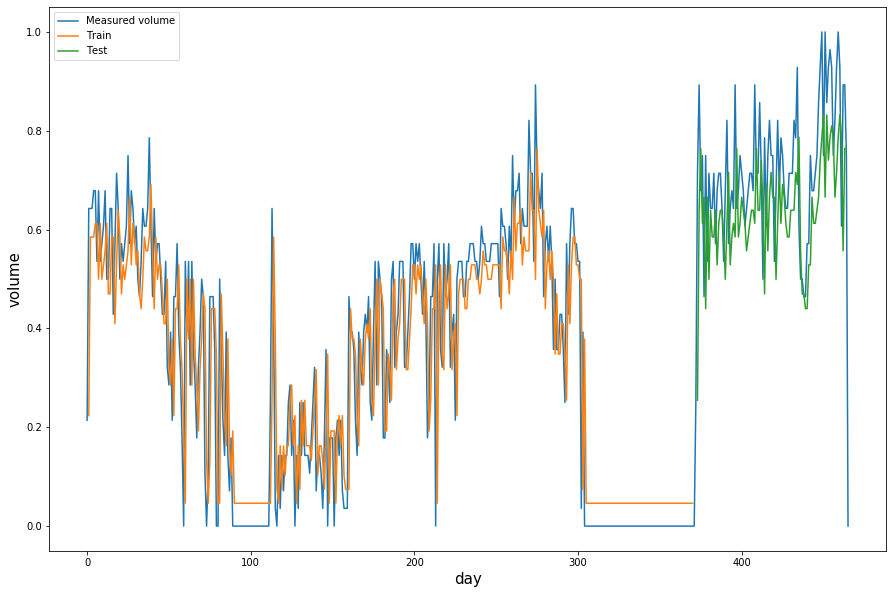

In [135]:
#
plt.figure(figsize = (15,10))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(df)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(df), label='Measured volume')
plt.plot(trainPredictPlot, label='Train')
plt.plot(testPredictPlot, label='Test')
plt.legend()

plt.xlabel('day', fontsize=15);
plt.ylabel('volume', fontsize=15);
plt.show()